# System settings and packages

In [23]:
# Python ≥3.5 is required

import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import random
import numpy as np
import pandas as pd
import os
# import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
import matplotlib.image as mpimg

from os import listdir
from os.path import isfile, join
import re

from PIL import Image
import glob

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

ModuleNotFoundError: No module named 'tensorflow'

In [24]:
import matplotlib.image as mpimg

from os import listdir
from os.path import isfile, join
import re

from PIL import Image
import glob

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Specifying paths

In [ ]:
# Where to save the figures

PROJECT_ROOT_DIR = "output"
CHAPTER_ID = "Classification"
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Checking out the data

In [2]:
datapath = os.path.join("input", "sample_segmented_images", "")

In [3]:
train_df = pd.read_csv(datapath + "seg_train_sample_100.csv", sep = ';')

In [4]:
train_df.head(10)

,image,species,individual_id
0,0a572d02a1ed8e.png,minke_whale,0940fc2c3809
1,0a0ae8699f1a5a.png,beluga,af02c0601c6e
2,0a0cedc8ac6499.png,melon_headed_whale,fa870e1ae82d
3,0a0d83708b4fdc.png,bottlenose_dolphin,c2705f9e75c8
4,0a0e4b82b9f3ee.png,humpback_whale,02f5c5ee9c2a
5,0a0e90fb154acf.png,false_killer_whale,f7bb4f9a9d1a
6,0a0f53c069bffc.png,spinner_dolphin,1b9d07e72110
7,0a01b620a7915b.png,blue_whale,7c9f2b782eed
8,0a1bcf1da2b695.png,beluga,d53bc5d9dbfe
9,0a1c741127059b.png,bottlenose_dolphin,a43daee90cbc


In [5]:
train_df['species']. value_counts()

beluga                       20
bottlenose_dolphin           17
humpback_whale               16
blue_whale                    7
spinner_dolphin               6
minke_whale                   4
false_killer_whale            4
kiler_whale                   3
melon_headed_whale            3
bottlenose_dolpin             2
long_finned_pilot_whale       2
common_dolphin                2
dusky_dolphin                 2
short_finned_pilot_whale      2
fin_whale                     2
pantropic_spotted_dolphin     1
killer_whale                  1
cuviers_beaked_whale          1
southern_right_whale          1
gray_whale                    1
spotted_dolphin               1
pilot_whale                   1
pygmy_killer_whale            1
Name: species, dtype: int64

We have some typos in the species:

E.g., there is bottlenose_dolphin and bottlenose_dolpin, kiler_whale and killer_whale. Obviously, it is typos. Also, globis and pilot_whale are short_finned_pilot_whale

We thus need to correct the labels:


In [6]:
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [7]:
train_df['species']. value_counts()

beluga                       20
bottlenose_dolphin           19
humpback_whale               16
blue_whale                    7
spinner_dolphin               6
minke_whale                   4
killer_whale                  4
false_killer_whale            4
melon_headed_whale            3
short_finned_pilot_whale      3
long_finned_pilot_whale       2
common_dolphin                2
dusky_dolphin                 2
fin_whale                     2
pantropic_spotted_dolphin     1
cuviers_beaked_whale          1
southern_right_whale          1
gray_whale                    1
spotted_dolphin               1
pygmy_killer_whale            1
Name: species, dtype: int64

In [8]:
y = train_df["species"]

In [9]:
y.shape

(100,)

In [10]:
train_df['individual_id']. value_counts() 

4a67e64bd3b7    2
0940fc2c3809    1
7bedeacdc4d2    1
26c9084d9e34    1
6025575fb0cf    1
               ..
31f748b822f4    1
be3742892267    1
650f189103b8    1
54c26574e46b    1
02da0e68dccd    1
Name: individual_id, Length: 99, dtype: int64

In [13]:
# Implement a switch between dummy and full data
full_data_switch_on = False # if the full data set should be used, this switch need to be set to true

# Loading the Images

Define path to data depending on the switch

In [14]:
if full_data_switch_on == False:
    #set path to the full data set
    ROOT_PATH_DATA = "input/"
    PATH_DATA_TRAIN_SAMPLE = os.path.join(ROOT_PATH_DATA + "sample_segmented_images/seg_train_sample_100")
elif full_data_switch_on == True:
    ROOT_PATH_DATA = "input/"
    PATH_DATA_TRAIN_SAMPLE = os.path.join(ROOT_PATH_DATA + "full_set_segmented_images")
else:
    raise ValueError("Full data switch is not correctly defined")

In [15]:
# Defining function to list all pictures to include
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [18]:
filepaths_train_sample = list_files(PATH_DATA_TRAIN_SAMPLE)

In [20]:
### i don't know if we gonna need that
# Extract pic ids from files in consideration
#Correct pic ids
pic_ids_train_sample = np.array([])
for i in range(len(filepaths_train_sample)):
    file_short = filepaths_train_sample[i].replace(PATH_DATA_TRAIN_SAMPLE + "/", "SAMPLE/")
    pic_ids_train_sample = np.append(pic_ids_train_sample, file_short)

In [21]:
pic_ids_train_sample

array(['SAMPLE/0a100ed55f1c7e.png', 'SAMPLE/0a0cedc8ac6499.png',
       'SAMPLE/0a9f092e4e3e92.png', 'SAMPLE/0a07fcc5ab1b4d.png',
       'SAMPLE/0a3f7ed710605e.png', 'SAMPLE/0a1bcf1da2b695.png',
       'SAMPLE/0a4ef0609c5bb9.png', 'SAMPLE/0a99ad33a87739.png',
       'SAMPLE/0a23cedc1e719e.png', 'SAMPLE/0a39e7972b191c.png',
       'SAMPLE/0a93b0a0d4f3a7.png', 'SAMPLE/0a97d1e6751b0d.png',
       'SAMPLE/0a7dd6215c0916.png', 'SAMPLE/0a6da6533bd494.png',
       'SAMPLE/0a5f343d8435ce.png', 'SAMPLE/0a164ed77a3ed3.png',
       'SAMPLE/0a6bfeed7be2f4.png', 'SAMPLE/0a0802b2d2d759.png',
       'SAMPLE/0a53d2f897157c.png', 'SAMPLE/0a6a52264469b6.png',
       'SAMPLE/0a83ebfa98e751.png', 'SAMPLE/0a99cbb091b9b8.png',
       'SAMPLE/0a32fb56190d7c.png', 'SAMPLE/0a2d7ead9bec6c.png',
       'SAMPLE/0a40dccc6d5a6a.png', 'SAMPLE/0a380a45691ce5.png',
       'SAMPLE/0a312f2d4a679d.png', 'SAMPLE/0a14b0bc5bb868.png',
       'SAMPLE/0a3e6fa90daced.png', 'SAMPLE/0a550a7d4633b4.png',
       'SAMPLE/0a01b620a7

In [25]:
image_list = []
for filename in glob.glob(os.path.join(PATH_DATA_TRAIN_SAMPLE +'/*.png')):
    im=Image.open(filename)
    image_list.append(im)

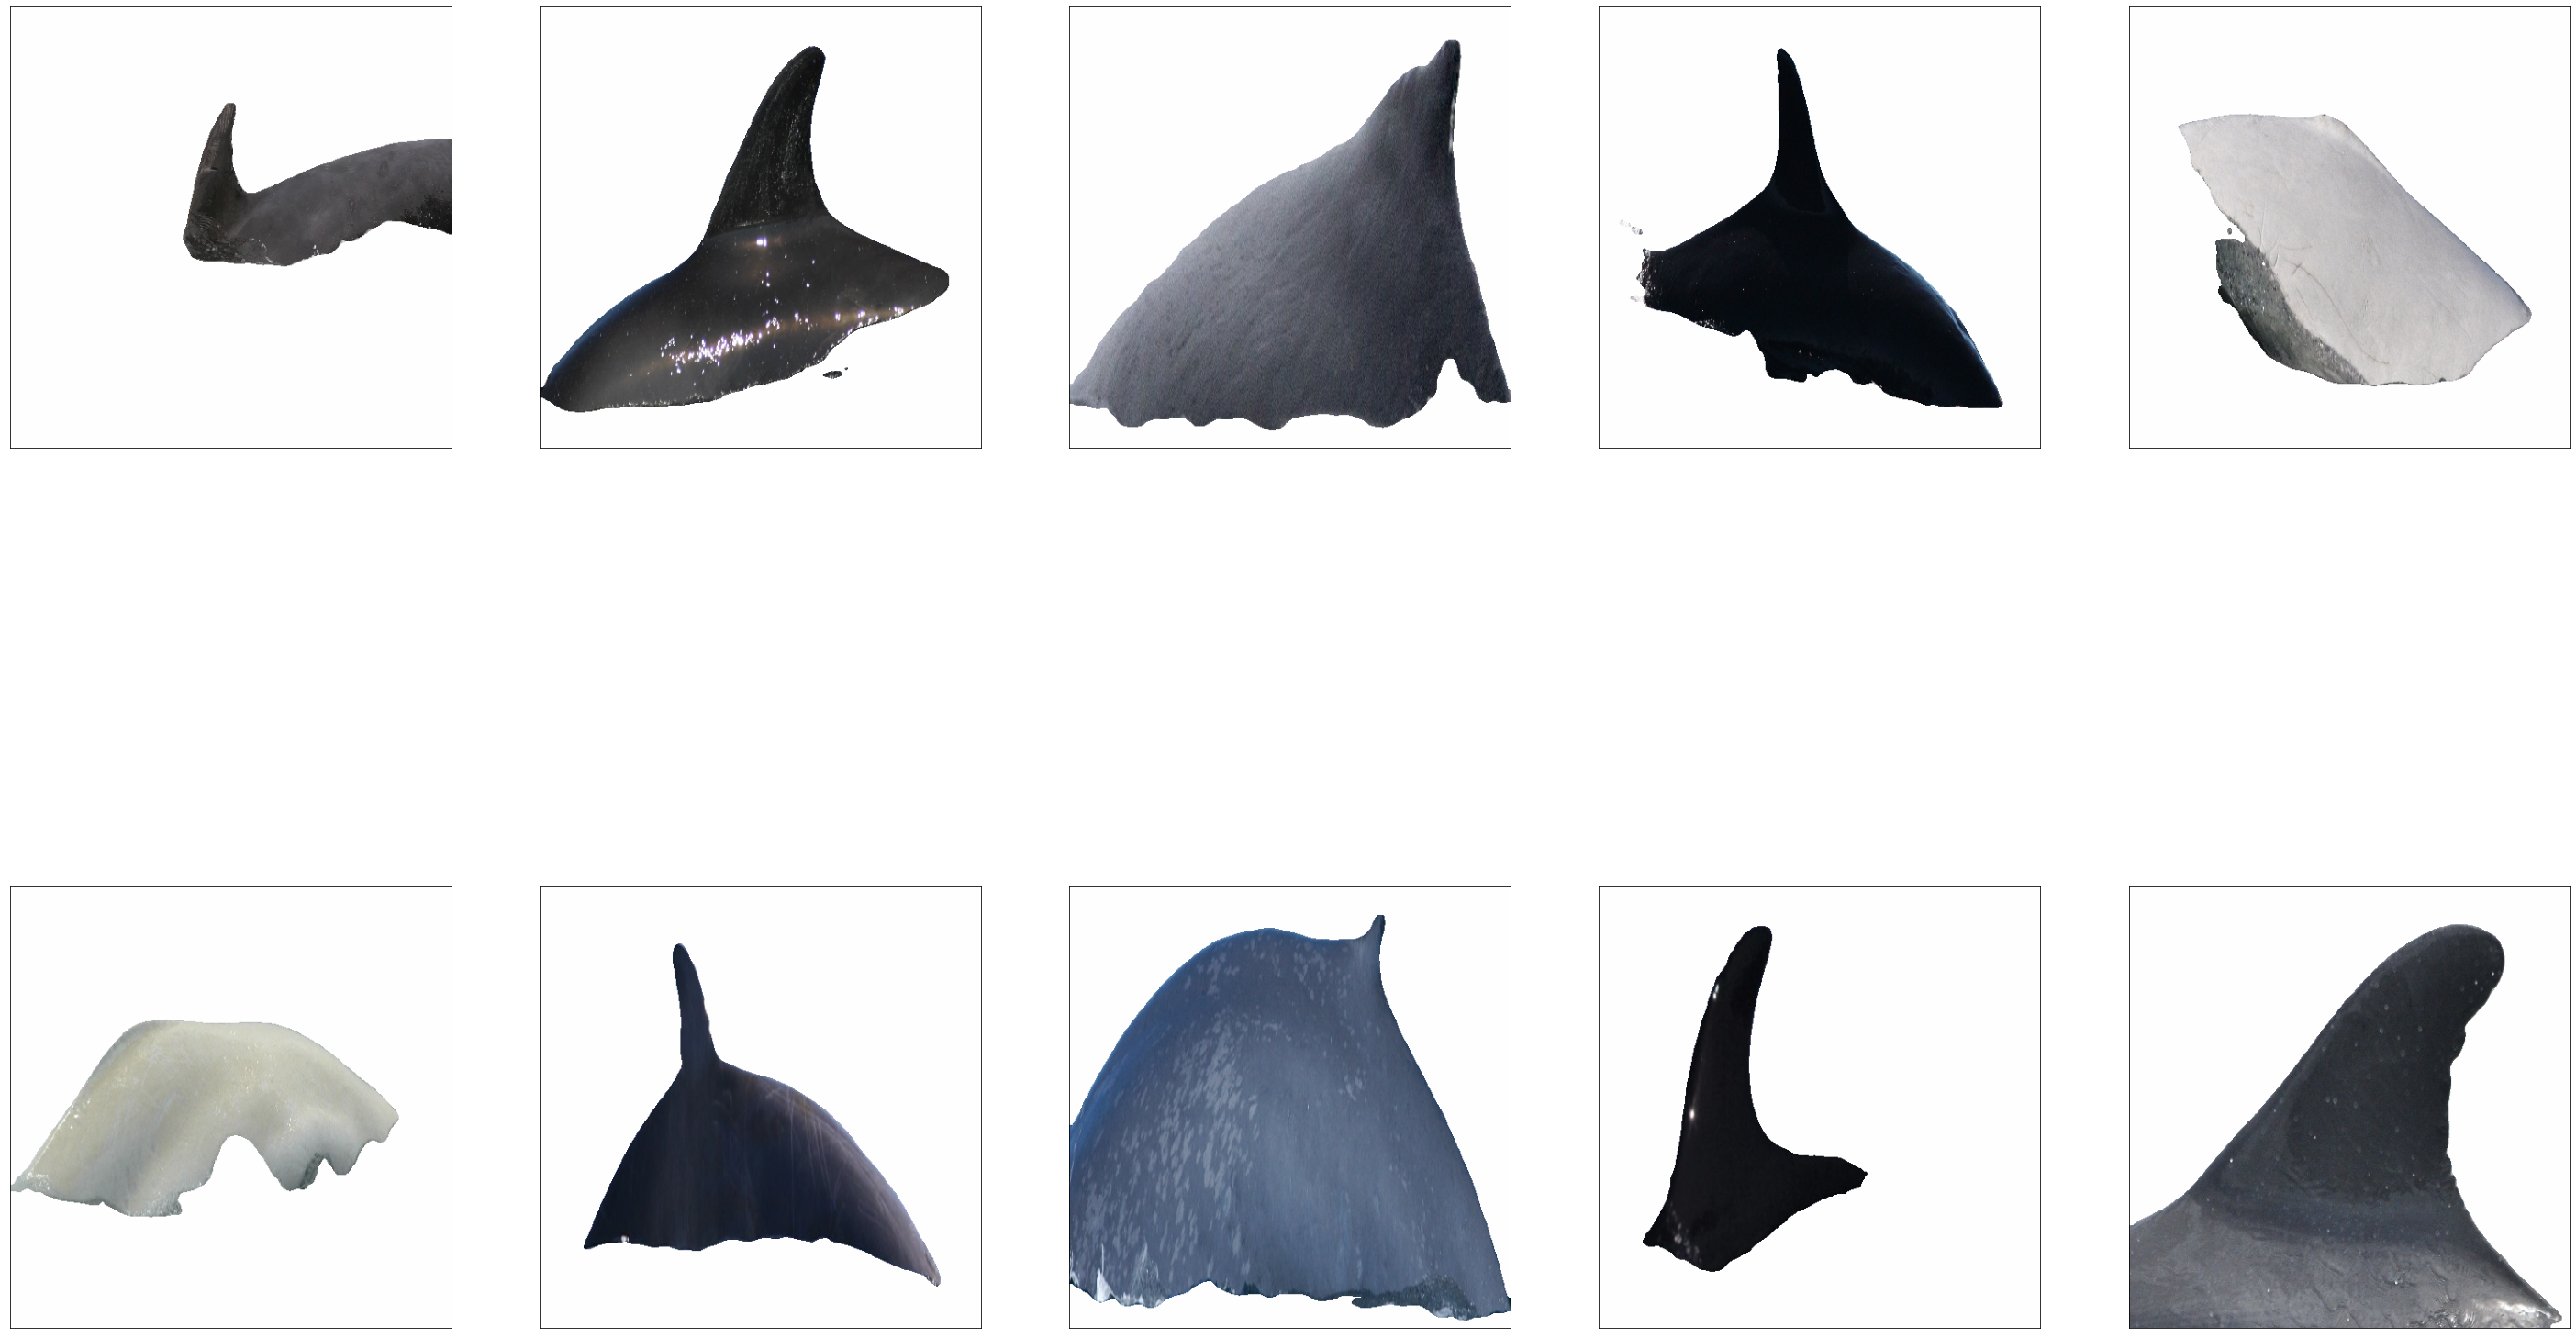

In [26]:
example_images = image_list[:10]
plt.figure(figsize=(50,50))
columns = 5
for i, image in enumerate(example_images):
    plt.subplot(int(len(example_images) / columns + 1), columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
#save_fig("sample_image_plot")
plt.show()

# Function to transform images into np.array

In [27]:
# Importing necessary libraries/functions
from PIL import Image as PIL_Image
import timeit


# Defining function that performs translation of jpg files into numerical representation
def pixel_transformation(target_pixel):
     
        # Run-time information
        start_time = timeit.default_timer()
        print(">... Starting pixel transformation for correct pictures for resolution: ", target_pixel, "x", target_pixel)

        # Initialize emtpy array of fitting length
        array_length = target_pixel*target_pixel*3 #Times 3 as we have 3 values (RGB) per pixel
        loaded_pics_train_sample = np.empty([0,array_length])

        #Running trough all correctly worn image files
        for filename in filepaths_train_sample:
            # open picture
            pic = PIL_Image.open(filename)
            # Reduce size from original format to target format
            pic_resized = pic.resize((target_pixel, target_pixel))
            # Extract RGB data
            pic_data = np.array(pic_resized)
            # Include help array to reshape 3D-array(e.g.: 1024, 1024, 3) into 1D array
            help_array = np.reshape(pic_data,(pic_data.size,))
            # Stack each array onto each other to have one larger array of shape (#obs,#pixels*3)
            loaded_pics_train_sample = np.vstack((loaded_pics_train_sample, help_array))
        
        #End run-time information
        elapsed = timeit.default_timer() - start_time
        print("Finished", target_pixel, "x", target_pixel ,"pixel transformation for correct pictures. Run-time in seconds: ", round(elapsed,2))
 
        # Returning
        return loaded_pics_train_sample # array with dimension pixels x pixels x colors for each image

In [28]:
pictures_numerical = pixel_transformation(224) # We choose a resolution of 224x224 pixels for the images

>... Starting pixel transformation for correct pictures for resolution:  224 x 224
Finished 224 x 224 pixel transformation for correct pictures. Run-time in seconds:  6.6


In [29]:
# Number of features of one picture:
len(pictures_numerical)
len(pictures_numerical[40])

150528

In [ ]:
## victor: brauchen wir noch eine funktion, um den Bild-Array mit dem CSV zu kombinieren?
## damit wir einmal alles sauber zusammen ablegen? 
## die pic IDs sollten wir einbauen,
## damit wir es bei der fehleranalyse einfacher haben die bilder zu identifizieren, die fehler
## produzieren


# Function for storing dictionary in the appropriate folder
## hier müssen wir unbedingt irgendwann die Ordner Struktur glatt ziehen und entsprechend benennen
## es wär vielleicht sinnvoll, wenn wir in diesen Ordnern dann halt entweder das kombinierte dictionary von bild+csv haben
## jeweils für dummy_set und full_set - oder?

In [30]:
def store_dict(image_dict, target_pixel):
    if full_data_switch_on == True:
        file = open(("input/cleaned/img_data_full_"+str(target_pixel)+".pkl"),"wb")
        pickle.dump(image_dict, file)
        file.close()
        print("dictionary successfully stored in: input/cleaned/img_data_full_"+str(target_pixel)+".pkl")
    elif full_data_switch_on == False:
        file = open(("input/cleaned/img_data_sample_"+str(target_pixel)+".pkl"),"wb")
        pickle.dump(image_dict, file)
        file.close()
        print("dictionary successfully stored in: input/ccleaned/img_data_sample_"+str(target_pixel)+".pkl")
    else:
        raise ValueError("Full data switch is not correctly defined")

In [ ]:
# hier könnten wir uns noch überlegen, ob wir eine kombinierte Funktion schreiben, die die Pipeline automatisiert
# mit dem Ziel einmal nur die Ziel Pixelgröße einzugeben und dann das fertige dictionary im entsprechenden Ordner abgelegt zu haben

# Classification

# First: Logistic Multivariate Regression

In [38]:
from sklearn.linear_model import LogisticRegression

pictures_numerical_subset_10 = pictures_numerical[:10]

len(pictures_numerical_subset_10)

y_subset_10 = y[:10]

X, y = pictures_numerical_subset_10, y_subset_10

clf = LogisticRegression(random_state=0).fit(X,y)

In [39]:
clf.predict(X[:2, :])

array(['minke_whale', 'beluga'], dtype=object)

In [40]:
clf.predict_proba(X[:2, :])

array([[4.58561999e-24, 4.13263881e-21, 7.77439854e-26, 4.36133488e-09,
        2.44268990e-12, 7.32568016e-20, 9.99999996e-01, 5.94878168e-20],
       [9.99999999e-01, 1.64965309e-12, 1.52504455e-10, 7.04781148e-15,
        5.86507049e-10, 6.44872074e-13, 3.25274609e-16, 2.44454079e-10]])

In [41]:
clf.score(X, y)

1.0

In [42]:
clf.decision_function(X)


array([[-17.13810389, -10.33435779, -21.2153633 ,  17.35052536,
          9.86309176,  -7.45930283,  36.60101302,  -7.6675024 ],
       [ 23.68009488,  -3.45036122,   1.07626757,  -8.90596438,
          2.42325845,  -4.38962956, -11.98176702,   1.54810124],
       [-15.5937136 ,  -2.83554165,  -1.1347783 ,  -8.92227696,
          1.8435793 ,  36.54980075,  -7.48940474,  -2.41766485],
       [-18.96362319,  -6.3233059 ,  44.43703952,  -9.57741246,
          3.83938865, -11.4012849 , -20.0424619 ,  18.03166013],
       [ -3.98498064,  -5.86524089, -12.14508876,   7.54600392,
         22.26434835, -10.25360064,   0.56763268,   1.87092593],
       [ -5.96184214,  -4.64174661, -16.82641173,  24.5868963 ,
         10.00229845, -12.78116853,   6.45860822,  -0.83663402],
       [ -0.62804552,  -9.48210488,  10.29973874,  -6.98165221,
          4.77125451, -11.62104905, -19.23068042,  32.87253878],
       [ -4.4078461 ,  31.94720468,  -5.15288991,  -1.26413012,
         -0.07289766,  -4.8148552

In [ ]:
## implement a Principal Component Analysis

In [33]:
from sklearn.decomposition import PCA

In [31]:
pictures_numerical.shape

(100, 150528)

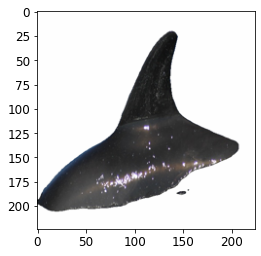

In [52]:
#taking a sample image to view
#Remember image is in the form of numpy array.
image_sample = pictures_numerical[1,:].reshape(224,224,3)
plt.imshow(image_sample.astype('uint8'))

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()# Fit on training set only.
scaler.fit(pictures_numerical)# Apply transform to both the training set and the test set.

train_img = scaler.transform(pictures_numerical)

In [55]:
pca = PCA(.95)

In [56]:
pca.fit(train_img)

PCA(n_components=0.95)

In [57]:
print(pca.components_)

[[-9.60629825e-16  1.98662302e-15  8.14655650e-16 ... -2.81436373e-03
  -2.86227910e-03 -2.83946670e-03]
 [-9.82328950e-16  4.82064416e-16  5.45631118e-16 ...  3.33540098e-04
   3.47104398e-04  3.65974614e-04]
 [ 2.64861882e-15 -3.53031876e-16  4.29036011e-15 ... -2.38010024e-03
  -2.37394429e-03 -2.30904856e-03]
 ...
 [ 3.04676423e-15 -3.39872066e-16 -1.64015081e-15 ...  1.60827271e-03
   1.45525585e-03  1.56843122e-03]
 [ 1.09967037e-15 -2.05193124e-16 -3.09971958e-15 ...  2.87066693e-03
   2.94469659e-03  2.87660372e-03]
 [-1.26784128e-15 -2.52233363e-15  1.48074638e-15 ...  2.78542159e-03
   2.49793732e-03  2.55927023e-03]]


In [58]:
pca.components_.shape

(58, 150528)

In [46]:
# Defining how much variance you want to have explained:
threshold = 0.95

pca = PCA()
pca.fit(pictures_numerical)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= threshold) + 1

In [45]:
# Showing number of features necessary to reach 95% variance explained
print("Features necessary to explain {}% variance: {}".format(threshold*100, d))

Features necessary to explain 95.0% variance: 56


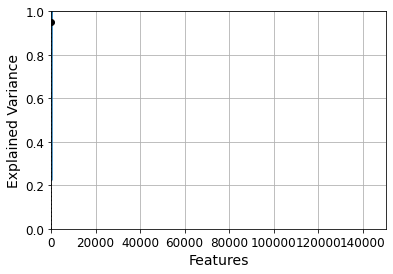

In [48]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, pictures_numerical.shape[1], 0, 1])
plt.xlabel("Features")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:")
plt.plot([0, d], [threshold, threshold], "k:")
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()